In [804]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.style as style
style.use('fivethirtyeight')
%config InlineBackend.figure_format ='retina'

In [805]:
from tempfile import NamedTemporaryFile
import urllib.request
import matplotlib.font_manager as fm

In [806]:
def newFont(github_url,sizeFont):
    headers = {}
    headers[
        "User-Agent"
    ] = "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"
    url = github_url + '?raw=true'  # You want the actual file, not some html
    request = urllib.request.Request(url, headers=headers)
    response = urllib.request.urlopen(request)
    f = NamedTemporaryFile(delete=False, suffix='.ttf')
    f.write(response.read())
    f.close()    
    return fm.FontProperties(fname=f.name, size=sizeFont)

github_url = 'https://www.1001fonts.com/download/font/playfair-display.regular.ttf'
heading_font = newFont(github_url,20)

github_url = 'https://www.1001fonts.com/download/font/roboto.regular.ttf'
subtitle_font = newFont(github_url,16)

In [807]:
def load_dead(districtRegion,start_date):
    dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
    df = pd.read_csv('./data/DRS_mortes.csv',delimiter=',',parse_dates=True, date_parser=dateparse)
    y=[]
    x=[]
    start=datetime.strptime(start_date, "%Y-%m-%d")+timedelta(days=10)
    start2=start.strftime("%Y-%m-%d")
    for i in range(0,len(df.date)):
        y.append(df[districtRegion].values[i])
        x.append(df.date.values[i])
    df2=pd.DataFrame(data=y,index=x,columns=[""])
    df2 =df2.apply (pd.to_numeric, errors='coerce')
    df2[start2:] = df2[start2:].replace({0:np.nan})
    df2 = df2.dropna()
    df2.index = pd.DatetimeIndex(df2.index)
    #interpolate missing data
    df2 = df2.reindex(pd.date_range(df2.index.min(), df2.index.max()), fill_value=np.nan)
    df2 = df2.interpolate(method='akima', axis=0).ffill().bfill()
    #string type for dates and integer for data
    df2 = df2.astype(int)
    df2.index = df2.index.astype(str)
    df2=df2[start_date:]
    return df2

In [808]:
version="119"
paramFile="data/param_optimized_Yabox_HistMin"+version+".csv"
dfparam = pd.read_csv(paramFile)
display(dfparam)
DRS=dfparam.DRS

,DRS,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,DRS 01 - Grande São Paulo,2020-03-17,200,12401753,0,0,77,0,144,28,0.15,0.6916,0.0
1,DRS 02 - Araçatuba,2020-03-28,200,472813,0,0,101,0,228,170,0.15,0.2024,0.0
2,DRS 03 - Araraquara,2020-04-04,200,888473,0,0,237,0,107,153,0.15,0.5406,0.0
3,DRS 04 - Baixada Santista,2020-04-01,200,1075497,0,0,160,0,162,48,0.15,0.2889,0.0
4,DRS 05 - Barretos,2020-04-02,200,218591,0,0,243,0,21,235,0.15,0.4606,0.0
5,DRS 06 - Bauru,2020-03-30,200,1023523,0,0,13,0,145,69,0.15,0.7871,0.0
6,DRS 07 - Campinas,2020-04-03,200,2285426,0,0,142,0,161,31,0.15,0.8110,0.0
7,DRS 08 - Franca,2020-04-04,200,269546,0,0,81,0,56,12,0.15,0.4050,0.0
8,DRS 09 - Marília,2020-04-01,200,5000,0,0,0,0,0,0,0.15,0.4000,0.1
9,DRS 10 - Piracicaba,2020-04-01,200,10000,0,0,0,0,1,0,0.15,0.4000,0.1


In [809]:
districtRegion=DRS[0]
display(districtRegion)
start_date=dfparam.loc[dfparam.DRS==districtRegion,'start-date'].values[0]
display(start_date)
dead=load_dead(districtRegion,start_date)

'DRS 01 - Grande São Paulo'

'2020-03-17'

In [810]:
size = len(dead)
dead['date'] = dead.index
tspan=np.arange(0, size, 1)
dead.index=tspan
dead.columns=['deaths','date']

display(dead)

,deaths,date
0,1,2020-03-17
1,3,2020-03-18
2,5,2020-03-19
3,9,2020-03-20
4,0,2020-03-21
...,...,...
343,31770,2021-02-23
344,31926,2021-02-24
345,32069,2021-02-25
346,32178,2021-02-26


In [811]:
import unicodedata

def plotFT(title,subTitle):
    
    #prepare plotting
    color_bg = '#FEF1E5'
    # lighter_highlight = '#FAE6E1'
    darker_highlight = '#FBEADC'
    plt.rc('font', size=14)
    
    fig, ax = plt.subplots(figsize=(15, 10),facecolor=color_bg)
    ax.patch.set_facecolor(darker_highlight)

    # Adding a title and a subtitle
    ax.text(x = 0.02, y = 1.14, s = title,
                fontsize = 26, weight = 'bold', alpha = .75,transform=ax.transAxes, 
                fontproperties=heading_font)
    ax.text(x = 0.02, y = 1.09,
                s = subTitle,
                fontsize = 20, alpha = .85,transform=ax.transAxes, 
                fontproperties=subtitle_font)

    # Hide the left, right and top spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.annotate('Modeling Team ATS with support of IPT', 
    xy=(1.04, 0.1), xycoords='axes fraction',
    xytext=(0, 0), textcoords='offset points',
    ha='right',rotation=90,fontproperties=subtitle_font,fontsize = 16)
    plt.annotate('Dr. Guilherme Araujo Lima da Silva - gasilva@ats4i.com.br', 
    xy=(1.045,0.1), xycoords='axes fraction',
    xytext=(0, 0), textcoords='offset points',
    ha='left',rotation=90,fontproperties=subtitle_font,fontsize = 16)

    fig.tight_layout()
    
    return fig,ax
    

def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

In [812]:
dR = strip_accents(districtRegion)
df = loadDataFrame('./data/SEAIRD_sigmaOpt_'+dR+version+'.pkl')

display(df)

,susceptible,exposed,asymptomatic,infected,recovered,deaths
date,,,,,,
2020-03-22,1.562346e+07,0.000000e+00,0.000000e+00,1.059803e+02,0.000000e+00,91.874160
2020-03-23,1.561046e+07,1.300066e+04,1.284982e+00,1.065374e+02,4.774127e+00,91.874160
2020-03-24,1.559707e+07,2.637690e+04,5.170605e+00,1.088288e+02,9.330002e+00,91.874160
2020-03-25,1.558287e+07,4.056604e+04,1.176688e+01,1.129278e+02,1.366689e+01,91.874160
2020-03-26,1.556739e+07,5.602897e+04,2.127222e+01,1.189666e+02,1.777686e+01,91.874160
...,...,...,...,...,...,...
2021-09-11,0.000000e+00,9.723666e+06,1.997943e+06,1.327777e+06,2.524763e+06,49212.067122
2021-09-12,0.000000e+00,9.711085e+06,1.999772e+06,1.328984e+06,2.534256e+06,49262.430164
2021-09-13,0.000000e+00,9.698521e+06,2.001586e+06,1.330182e+06,2.543759e+06,49312.448549


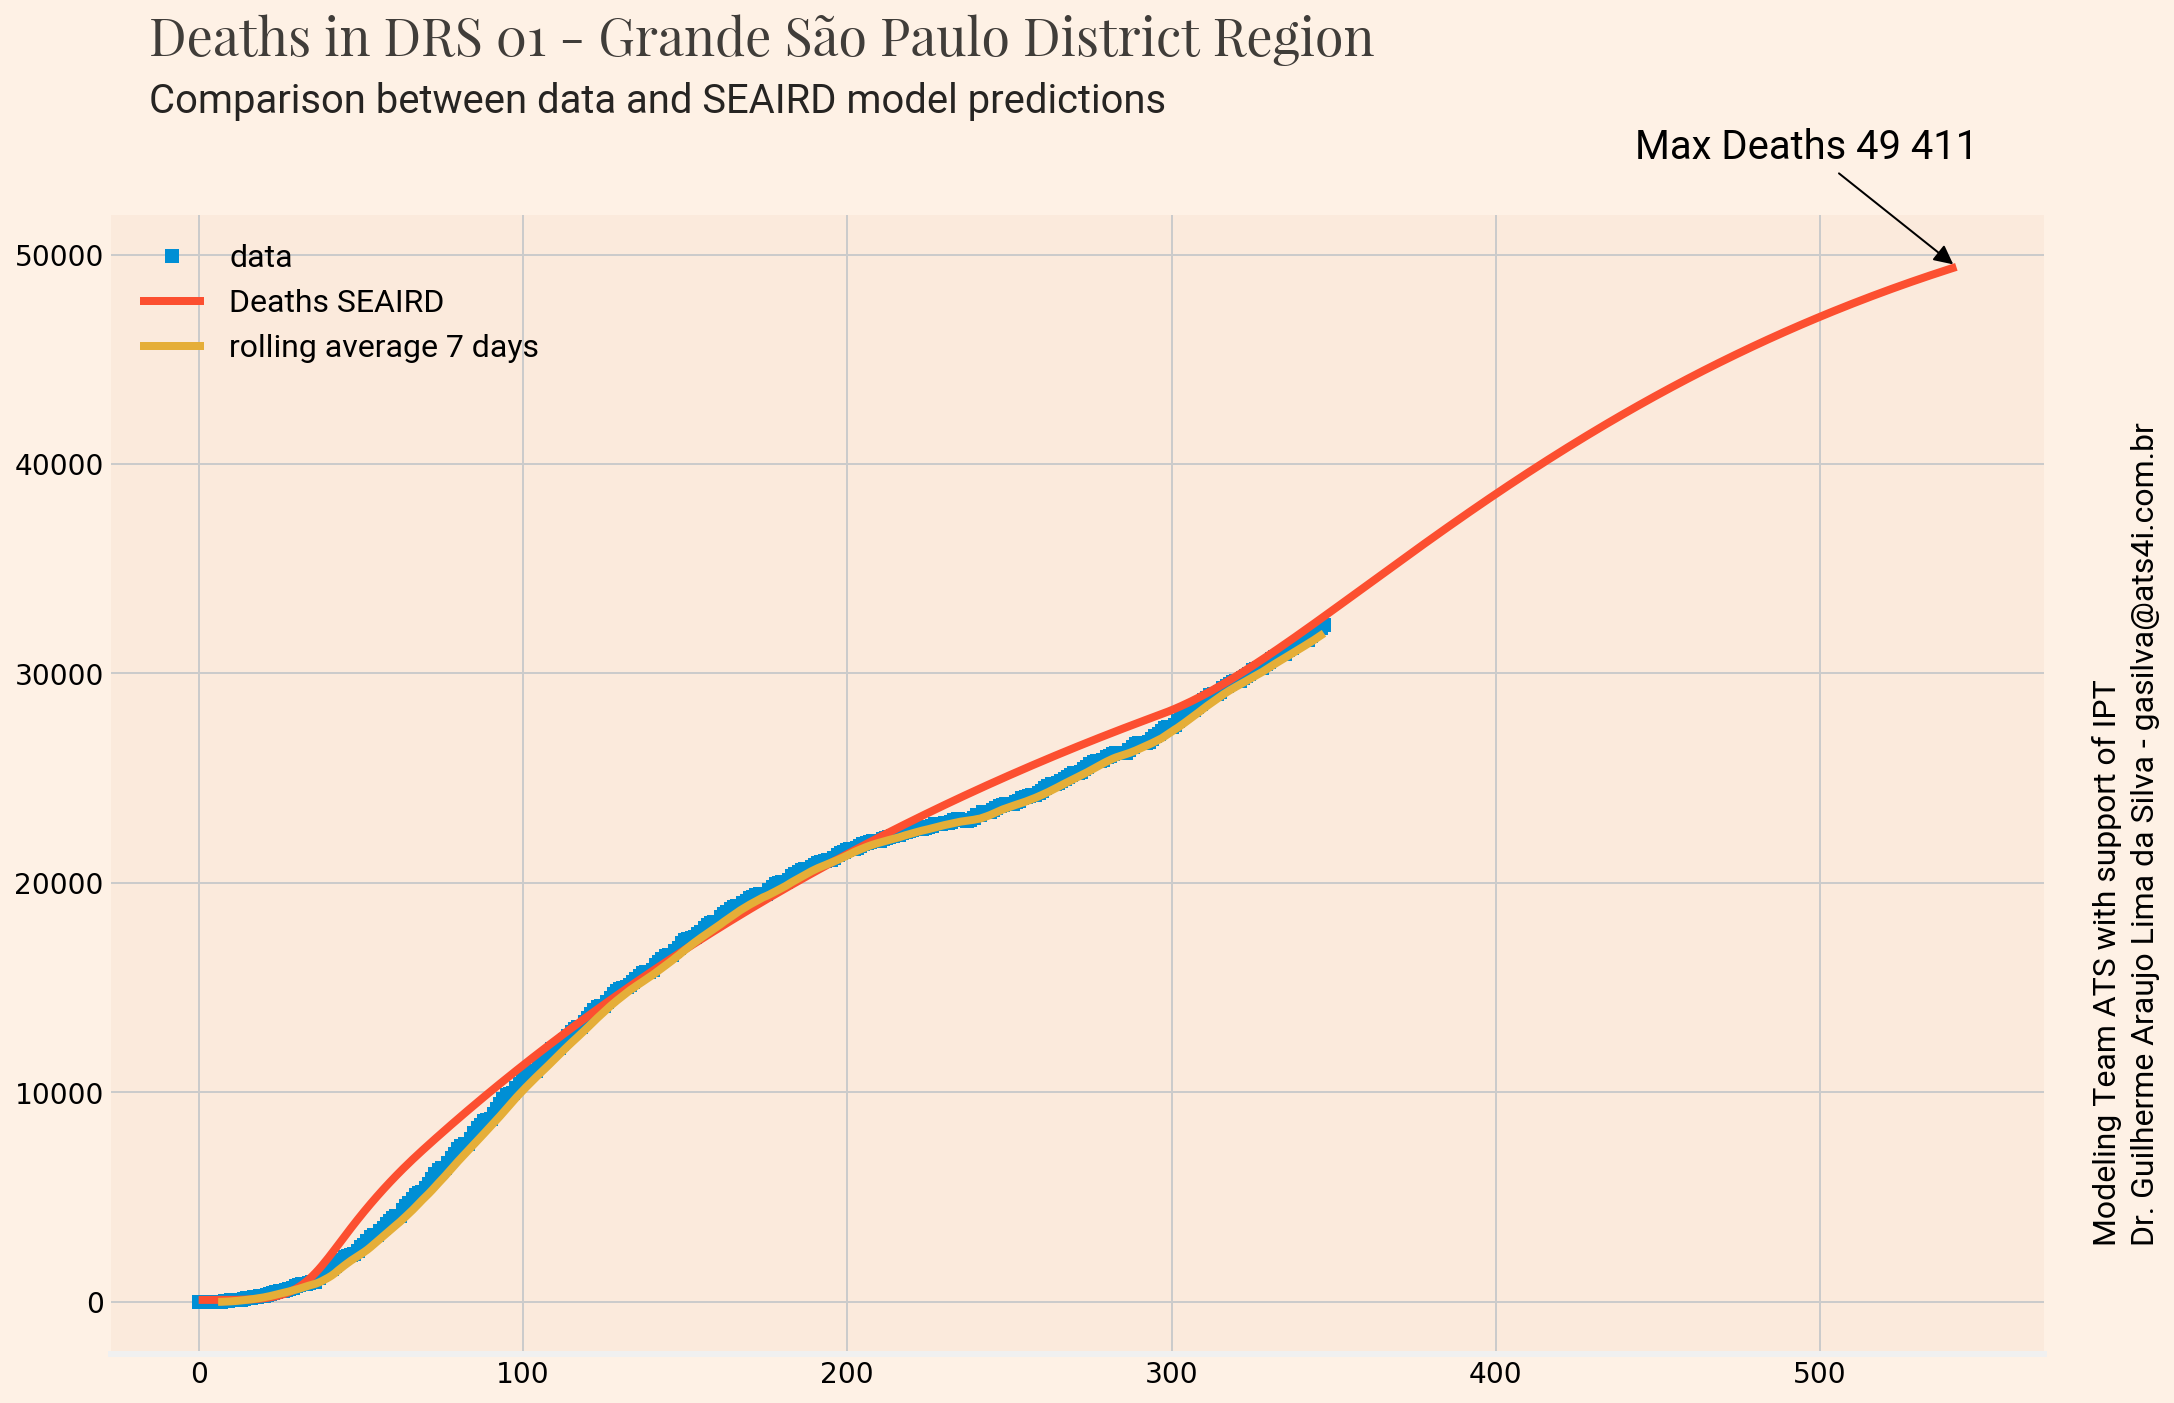

In [813]:
fig,ax = plotFT("Deaths in "+districtRegion+" District Region","Comparison between data and SEAIRD model predictions")

tspan3=np.arange(0, len(df['deaths'].values), 1)
maxD=max(df['deaths'])
maxInd=tspan3[df['deaths']==max(df['deaths'])][0]
ax.annotate("Max Deaths {:,}".format(int(df['deaths'].nlargest(1))).replace(',', ' '), 
     xy=(maxInd,maxD), 
     xytext=(-75,50), textcoords='offset points', ha='center', va='bottom',
    arrowprops=dict(arrowstyle='-|>', color='black', lw=1),fontsize=20,fontproperties=subtitle_font)
ax.plot(tspan,dead.iloc[:,0].values,'s',label='data')
ax.plot(tspan3,df['deaths'].values,'-',label="Deaths SEAIRD")
ax.plot(dead.iloc[:,0].rolling(7).mean(),'-',label='rolling average 7 days')
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)

In [814]:
from datetime import datetime

date_format="%Y-%m-%d"
lastDate=str(dead.date.values[-1])[:10]
display(lastDate)
finalDate=df.index[-1].strftime(date_format)
display(finalDate)
a = datetime.strptime(finalDate, date_format)
b = datetime.strptime(lastDate, date_format)
delta = a - b
print(delta.days)

df['error']=0
mask = (df['error'].index > lastDate)
df.loc[mask,'error']= (pd.to_datetime(df['error'].loc[mask].index)- \
        pd.to_datetime(dead.date.values[-1])).days*0.1/delta.days*df['deaths'].loc[mask]

'2021-02-27'

'2021-09-15'

200


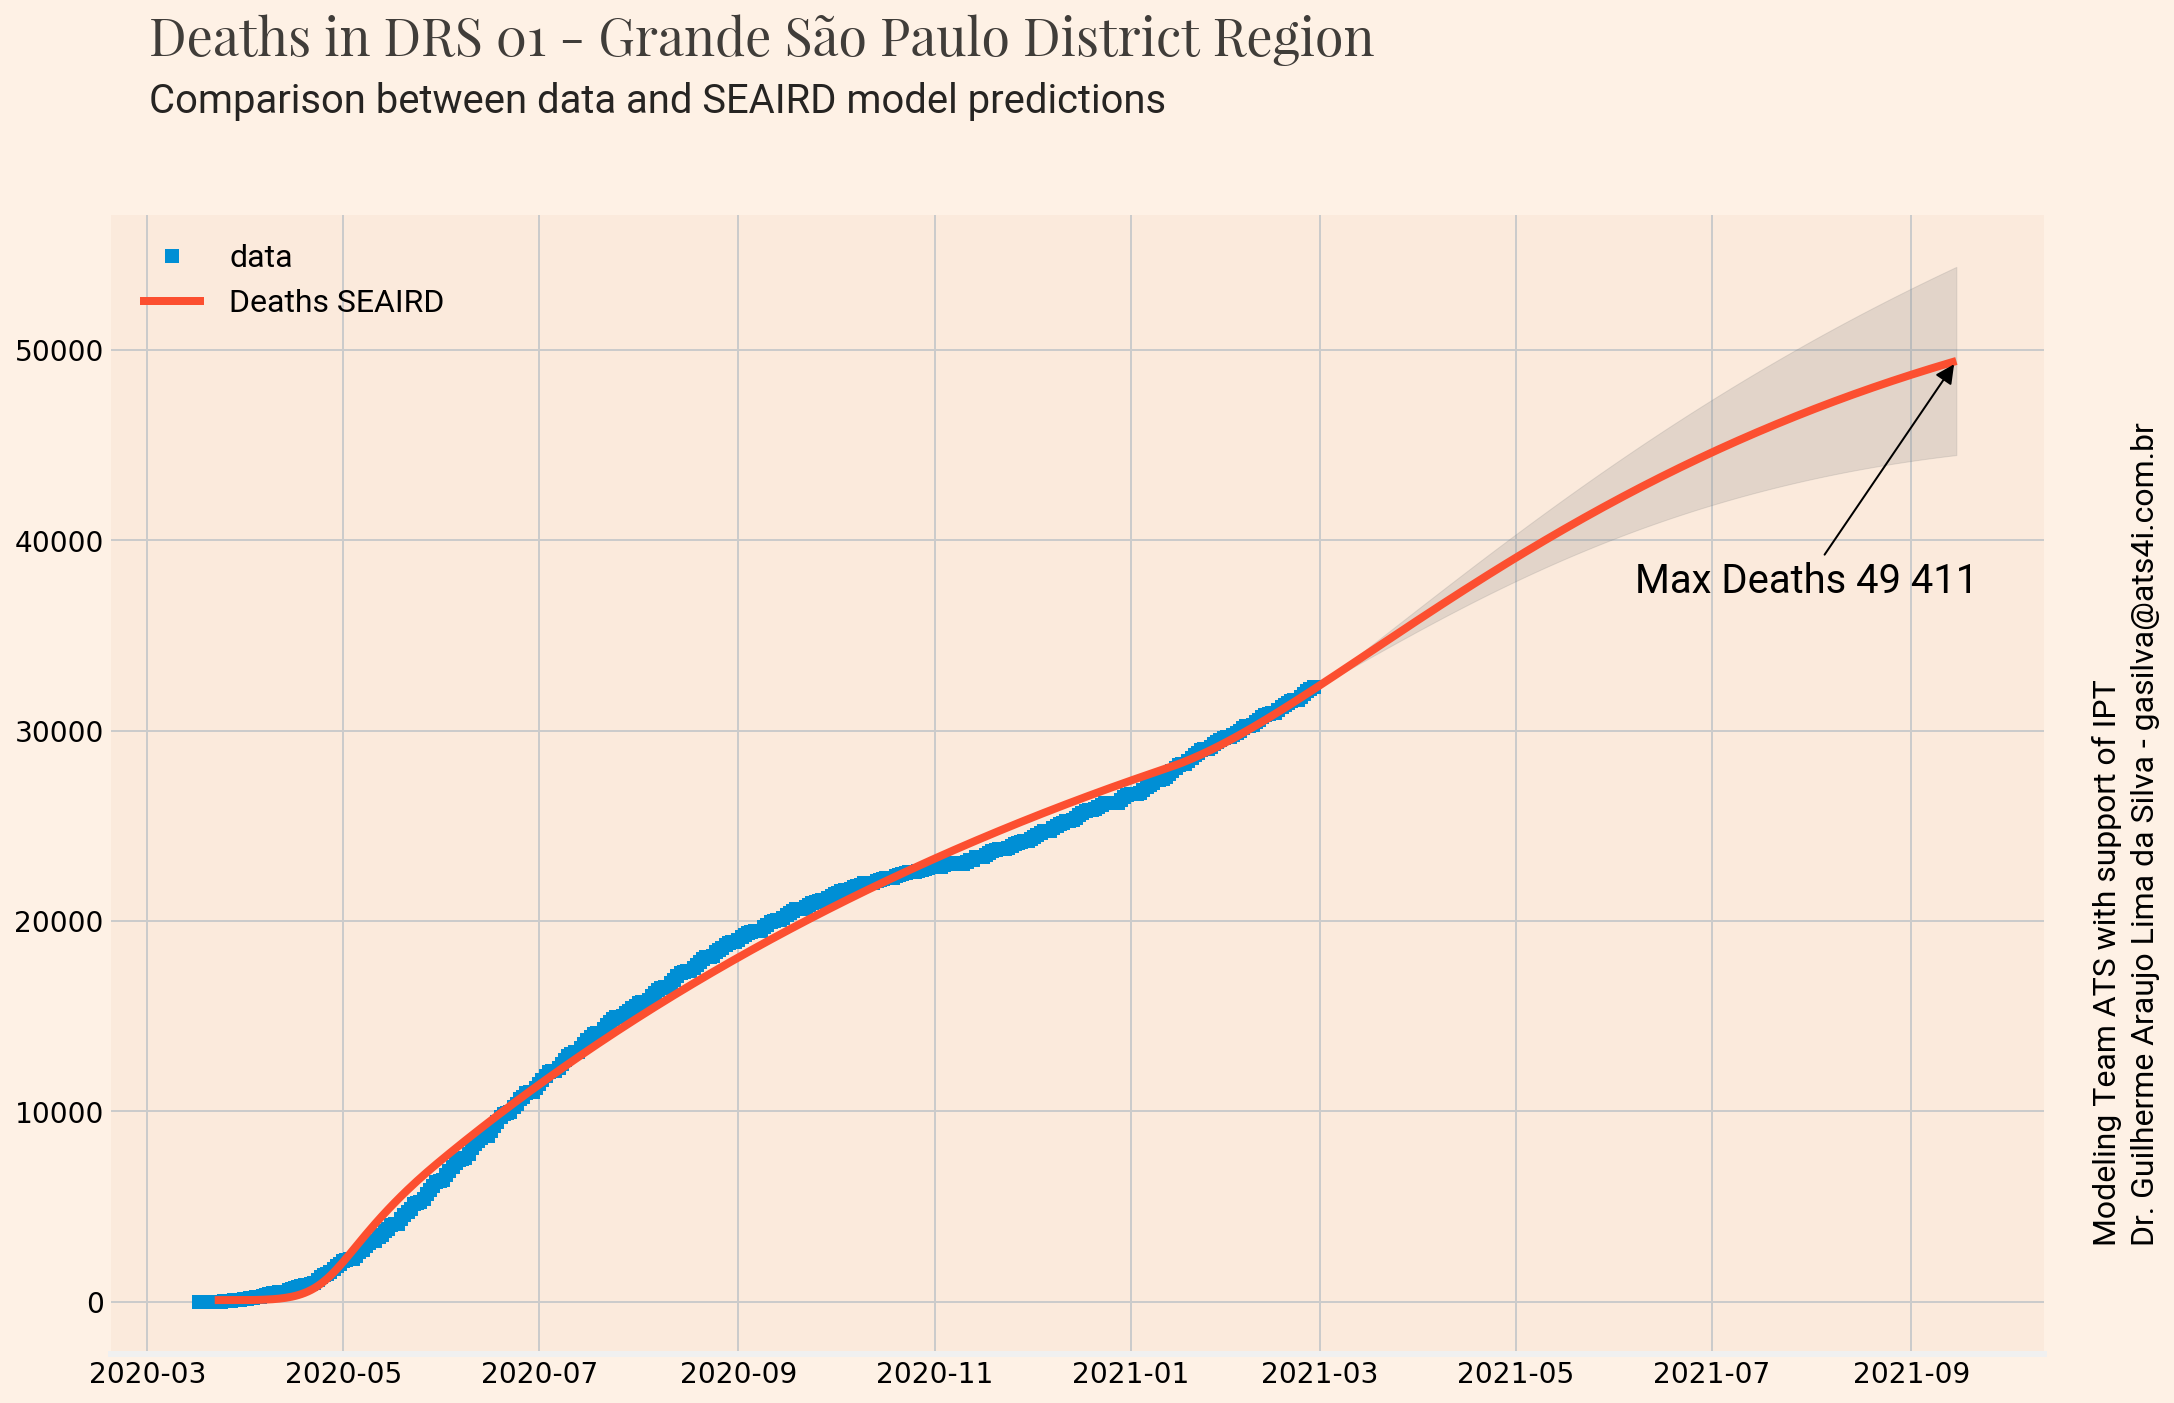

In [815]:
fig,ax = plotFT("Deaths in "+districtRegion+" District Region","Comparison between data and SEAIRD model predictions")
maxD=max(df['deaths'])
maxInd=df.index[df['deaths']==max(df['deaths'])][0]
ax.annotate("Max Deaths {:,}".format(int(df['deaths'].nlargest(1))).replace(',', ' '), 
     xy=(maxInd,maxD), 
     xytext=(-75,-120), textcoords='offset points', ha='center', va='bottom',
    arrowprops=dict(arrowstyle='-|>', color='black', lw=1),fontsize=20,fontproperties=subtitle_font)
dead['date'] = pd.to_datetime(dead['date'], format='%Y-%m-%d')
ax.plot(dead.date,dead.iloc[:,0].values,'s',label='data')
# ax.plot(dead.date,dead.iloc[:,0].rolling(7).mean(),'-',label='rolling average 7 days')
ax.plot(df['deaths'],'-',label="Deaths SEAIRD")
plt.fill_between(df.index,df['deaths']-df['error'], df['deaths']+df['error'],color='gray', alpha=0.2)
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font,loc="upper left")

In [816]:
s2 = df.groupby([lambda x: x.year, lambda x: x.month]).mean()
display(s2)

susceptible       exposed  asymptomatic      infected     recovered  \
2020 3   1.555028e+07  7.310778e+04  4.168824e+01  1.324293e+02  1.871644e+01   
     4   1.129903e+07  4.313463e+06  6.144392e+03  4.193977e+03  3.004159e+02   
     5   1.995667e+05  1.529641e+07  6.980324e+04  4.660605e+04  6.349259e+03   
     6   5.824853e-06  1.525367e+07  1.993383e+05  1.328967e+05  2.828598e+04   
     7   2.270407e-07  1.495259e+07  3.514542e+05  2.341925e+05  7.221073e+04   
     8   3.641605e-06  1.465263e+07  4.899094e+05  3.263399e+05  1.382125e+05   
     9   1.230348e-08  1.436336e+07  6.115989e+05  4.072824e+05  2.219140e+05   
     10  7.374409e-08  1.407983e+07  7.200247e+05  4.793593e+05  3.223274e+05   
     11  1.451071e-07  1.380187e+07  8.164717e+05  5.434335e+05  4.374415e+05   
     12  6.324371e-07  1.352942e+07  9.018654e+05  6.001272e+05  5.657335e+05   
2021 1   9.974960e-08  1.321140e+07  1.005900e+06  6.692315e+05  7.086777e+05   
     2   1.042562e-13  1.273758e+07  1.195299e+06  7.952162e+05  8.645393e+05   
     3   7.717719e-11  1.226042e+07  1.371071e+06  9.120767e+05  1.045819e+06   
     4   2.048055e-10  1.178567e+07  1.527719e+06  1.016150e+06  1.256450e+06   
     5   2.397127e-10  1.132940e+07  1.660949e+06  1.104594e+06  1.487899e+06   
     6   1.536131e-08  1.089070e+07  1.773322e+06  1.179124e+06  1.736909e+06   
     7   2.166249e-07  1.046908e+07  1.866731e+06  1.241009e+06  2.000839e+06   
     8   5.838063e-06  1.005723e+07  1.944375e+06  1.292384e+06  2.281621e+06   
     9   3.266868e-10  9.761660e+06  1.992227e+06  1.324002e+06  2.496417e+06   

               deaths        error  
2020 3      91.928464     0.000000  
     4     542.697965     0.000000  
     5    4922.259570     0.000000  
     6    9442.905044     0.000000  
     7   13165.883344     0.000000  
     8   16504.607237     0.000000  
     9   19420.995224     0.000000  
     10  22015.611913     0.000000  
     11  24326.062740     0.000000  
     12  26377.245373     0.000000  
2021 1   28304.789909     0.000000  
     2   30848.108695     0.576374  
     3   34069.505378   294.087404  
     4   37444.044955   893.327470  
     5   40569.440277  1586.086097  
     6   43338.407163  2354.272602  
     7   45721.659025  3180.532813  
     8   47763.310314  4062.277463  
     9   49055.640209  4734.350734

In [817]:
s2PerMonth=s2.diff(periods = 1)
display(s2PerMonth)

susceptible       exposed   asymptomatic       infected  \
2020 3            NaN           NaN            NaN            NaN   
     4  -4.251247e+06  4.240356e+06    6102.703367    4061.547501   
     5  -1.109946e+07  1.098295e+07   63658.849683   42412.076434   
     6  -1.995667e+05 -4.273865e+04  129535.048451   86290.641730   
     7  -5.597812e-06 -3.010834e+05  152115.884373  101295.772275   
     8   3.414565e-06 -2.999649e+05  138455.203236   92147.469988   
     9  -3.629302e-06 -2.892689e+05  121689.498386   80942.481726   
     10  6.144060e-08 -2.835276e+05  108425.775699   72076.857876   
     11  7.136298e-08 -2.779609e+05   96447.026950   64074.232952   
     12  4.873300e-07 -2.724441e+05   85393.765712   56693.697993   
2021 1  -5.326875e-07 -3.180261e+05  104034.484355   69104.332549   
     2  -9.974950e-08 -4.738157e+05  189399.245023  125984.628974   
     3   7.707293e-11 -4.771601e+05  175771.891251  116860.528112   
     4   1.276283e-10 -4.747500e+05  156647.781203  104073.045896   
     5   3.490727e-11 -4.562701e+05  133230.625781   88443.865344   
     6   1.512160e-08 -4.386989e+05  112372.889444   74529.947895   
     7   2.012636e-07 -4.216223e+05   93408.336077   61885.458974   
     8   5.621438e-06 -4.118550e+05   77644.383936   51374.599829   
     9  -5.837736e-06 -2.955666e+05   47851.714959   31618.820693   

             recovered       deaths       error  
2020 3             NaN          NaN         NaN  
     4      281.699472   450.769502    0.000000  
     5     6048.842833  4379.561605    0.000000  
     6    21936.718839  4520.645474    0.000000  
     7    43924.752077  3722.978300    0.000000  
     8    66001.766473  3338.723893    0.000000  
     9    83701.469476  2916.387987    0.000000  
     10  100413.412250  2594.616690    0.000000  
     11  115114.076451  2310.450826    0.000000  
     12  128292.038899  2051.182633    0.000000  
2021 1   142944.237104  1927.544537    0.000000  
     2   155861.587810  2543.318785    0.576374  
     3   181280.121454  3221.396683  293.511030  
     4   210630.582263  3374.539577  599.240066  
     5   231449.443742  3125.395322  692.758627  
     6   249009.375447  2768.966886  768.186505  
     7   263930.452441  2383.251862  826.260211  
     8   280782.046211  2041.651289  881.744649  
     9   214796.069176  1292.329895  672.073271

In [818]:
dead2=dead.set_index('date')
#del dead2['diff']

d2=dead2.groupby([lambda x: x.year, lambda x: x.month]).mean()
d2PerMonth=d2.diff(periods = 1)

deadsDiff=[]
deadsDiff=pd.concat([d2PerMonth, s2PerMonth['deaths']], axis=1)
deadsDiff=deadsDiff.fillna(0)
deadsDiff.columns = ['data','SEAIRD']
display(deadsDiff)

data       SEAIRD
2020 3      0.000000     0.000000
     4    773.900000   450.769502
     5   3233.646237  4379.561605
     6   4914.887097  4520.645474
     7   4667.532258  3722.978300
     8   3713.096774  3338.723893
     9   2881.270968  2916.387987
     10  1945.470968  2594.616690
     11  1273.362366  2310.450826
     12  2054.831183  2051.182633
2021 1   2610.096774  1927.544537
     2   2838.616487  2543.318785
     3      0.000000  3221.396683
     4      0.000000  3374.539577
     5      0.000000  3125.395322
     6      0.000000  2768.966886
     7      0.000000  2383.251862
     8      0.000000  2041.651289
     9      0.000000  1292.329895

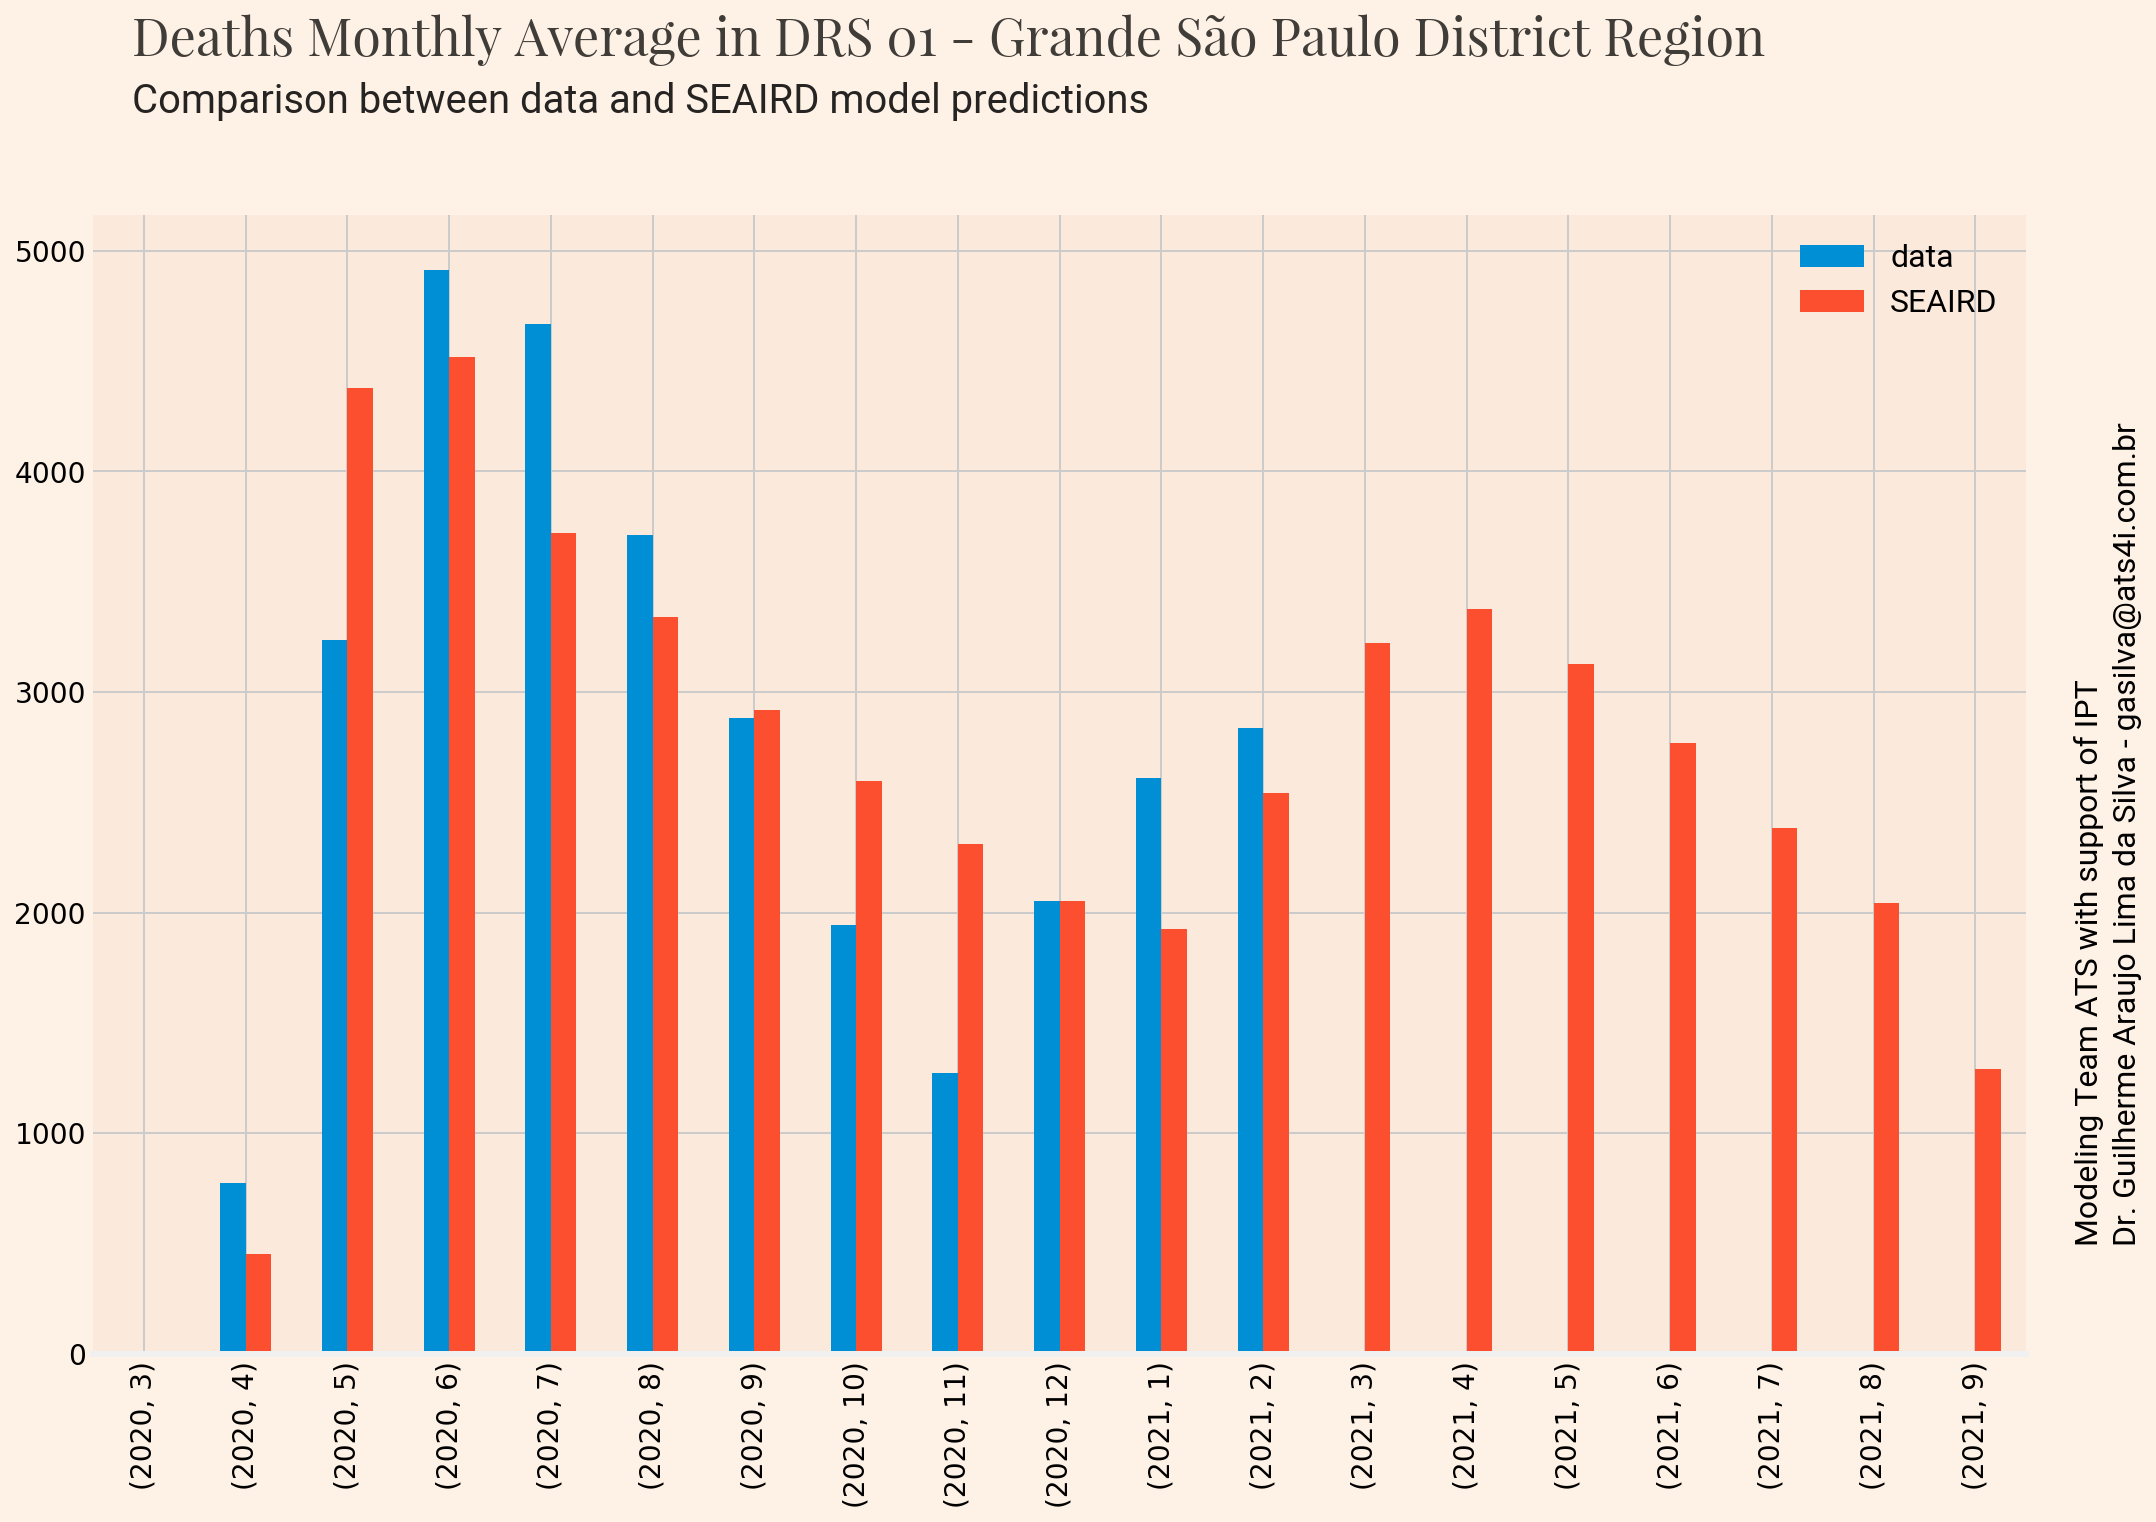

In [819]:
fig,ax = plotFT("Deaths Monthly Average in "+districtRegion+" District Region","Comparison between data and SEAIRD model predictions")
deadsDiff.plot(kind="bar",ax=ax)
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)


In [820]:
diffDead=np.diff(dead.iloc[:,0].T[:])
diffDead=np.insert(diffDead,0,0)
dead['diff']=diffDead
display(dead)

,deaths,date,diff
0,1,2020-03-17,0
1,3,2020-03-18,2
2,5,2020-03-19,2
3,9,2020-03-20,4
4,0,2020-03-21,-9
...,...,...,...
343,31770,2021-02-23,168
344,31926,2021-02-24,156
345,32069,2021-02-25,143
346,32178,2021-02-26,109


,deaths,date,diff
0,1,2020-03-17,0
1,3,2020-03-18,2
2,5,2020-03-19,2
3,9,2020-03-20,4
4,0,2020-03-21,-9
...,...,...,...
343,31770,2021-02-23,168
344,31926,2021-02-24,156
345,32069,2021-02-25,143
346,32178,2021-02-26,109


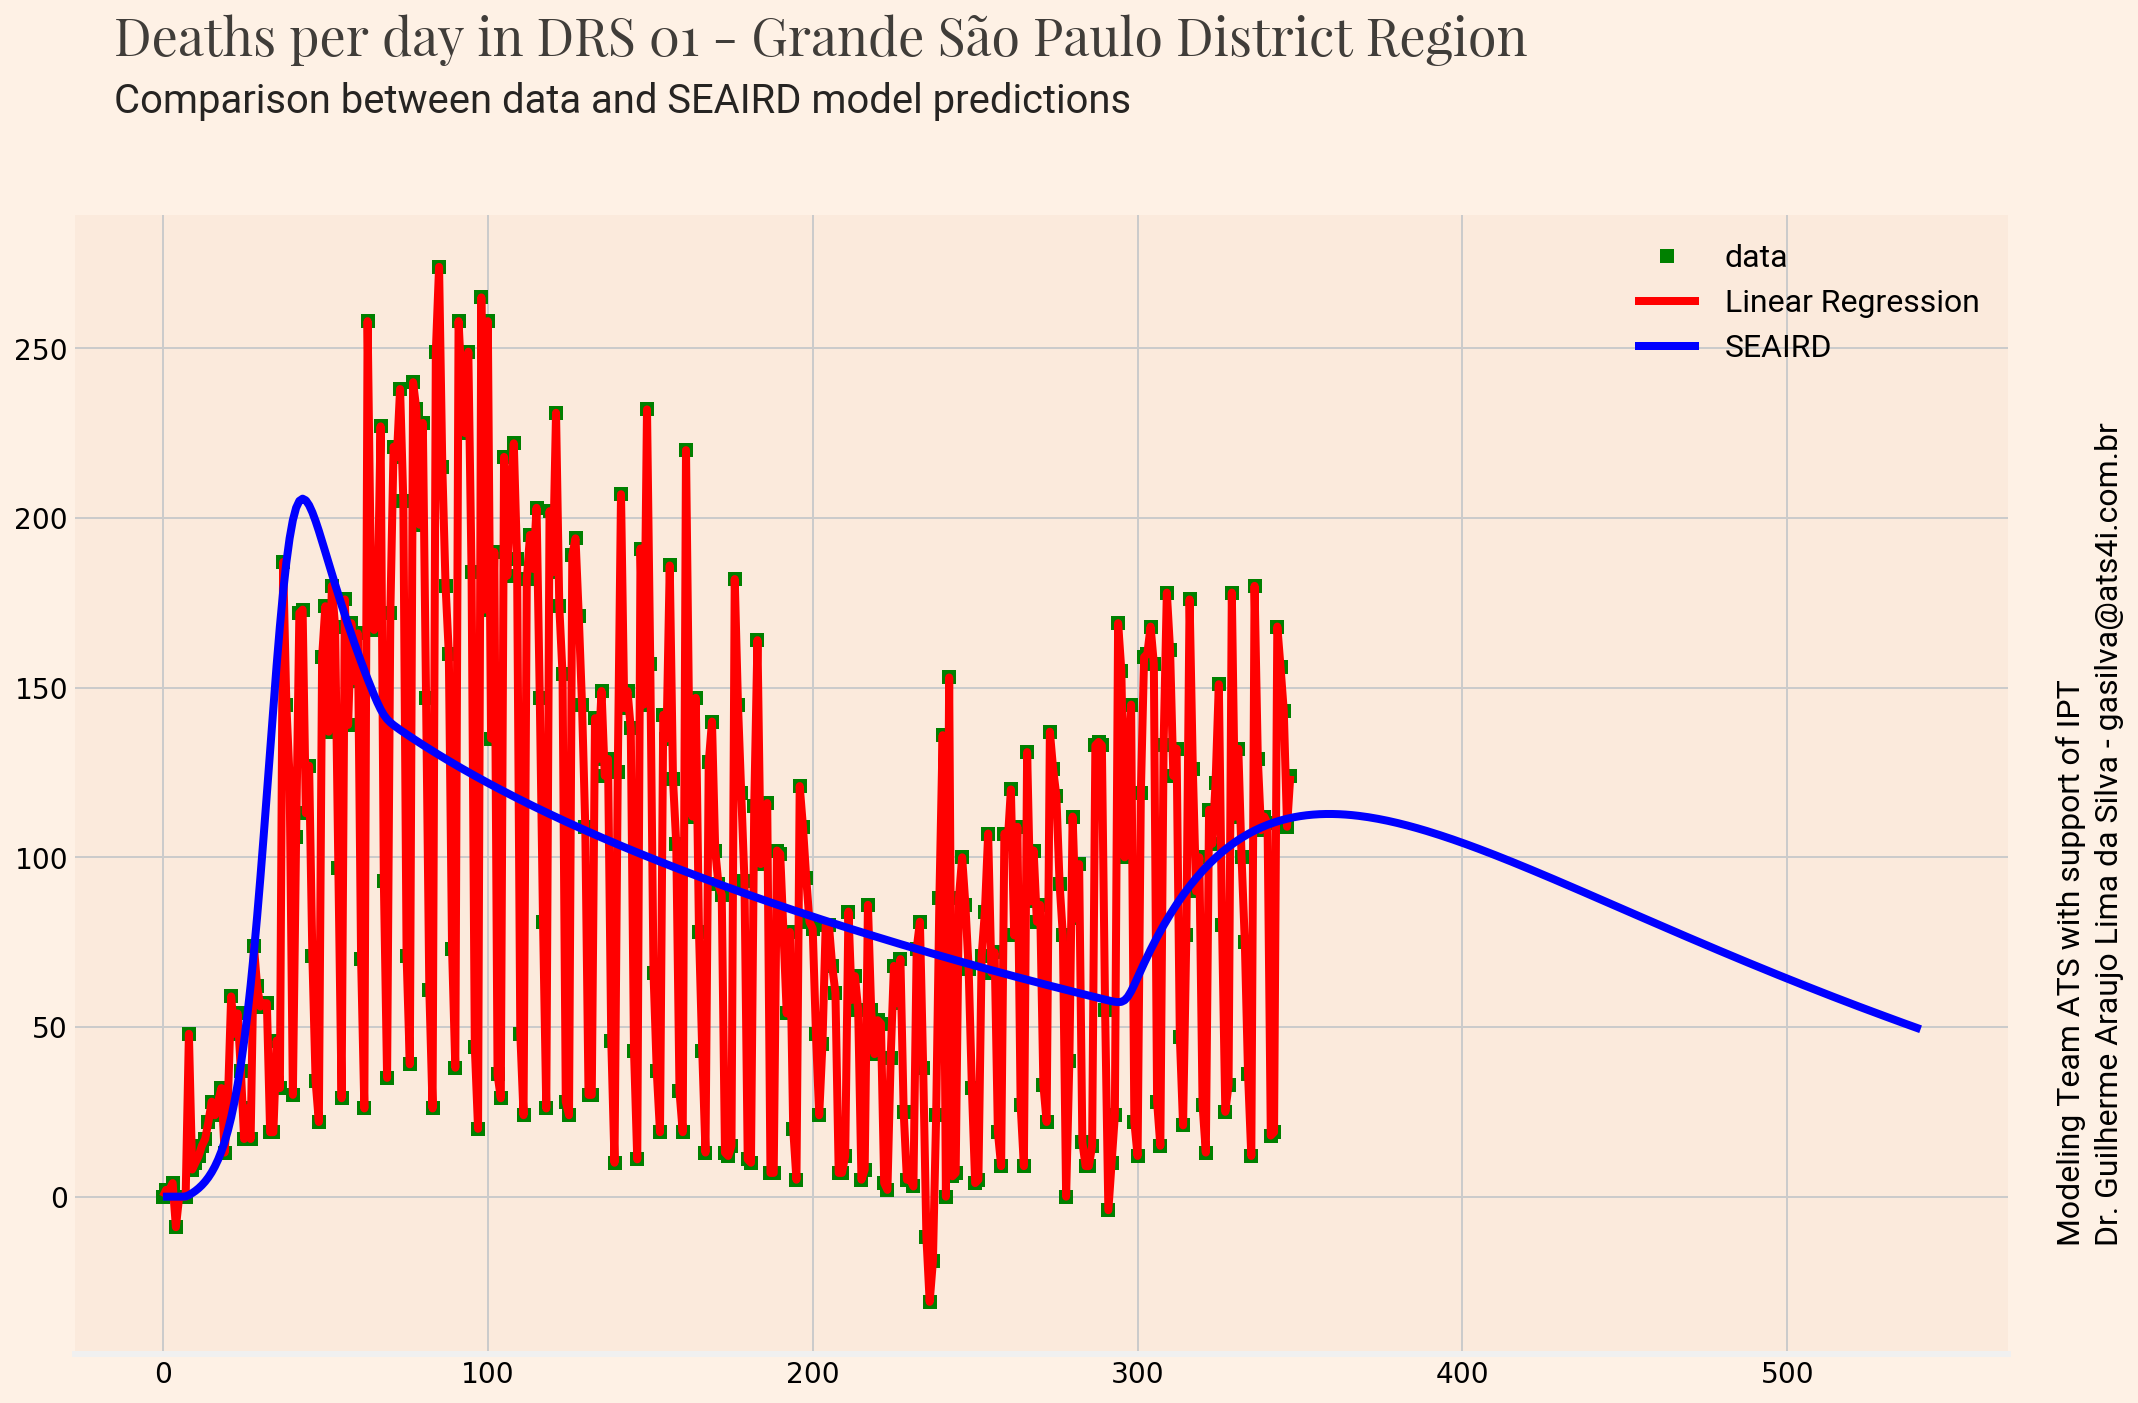

In [821]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()

regr.fit([dead.index.values.T], [dead['diff'].values])

tspan1=np.arange(0, size, 1)
results = regr.predict([tspan1])

display(dead)

fig,ax = plotFT("Deaths per day in "+districtRegion+" District Region","Comparison between data and SEAIRD model predictions")
ax.plot(dead['diff'],'gs',label='data')
ax.plot(tspan1,results[0],'r-',label='Linear Regression')
diffDeaths=np.diff(df['deaths'].values)
size4=len(diffDeaths)
ax.plot(np.arange(0, size4, 1),diffDeaths,'b',label='SEAIRD')
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)


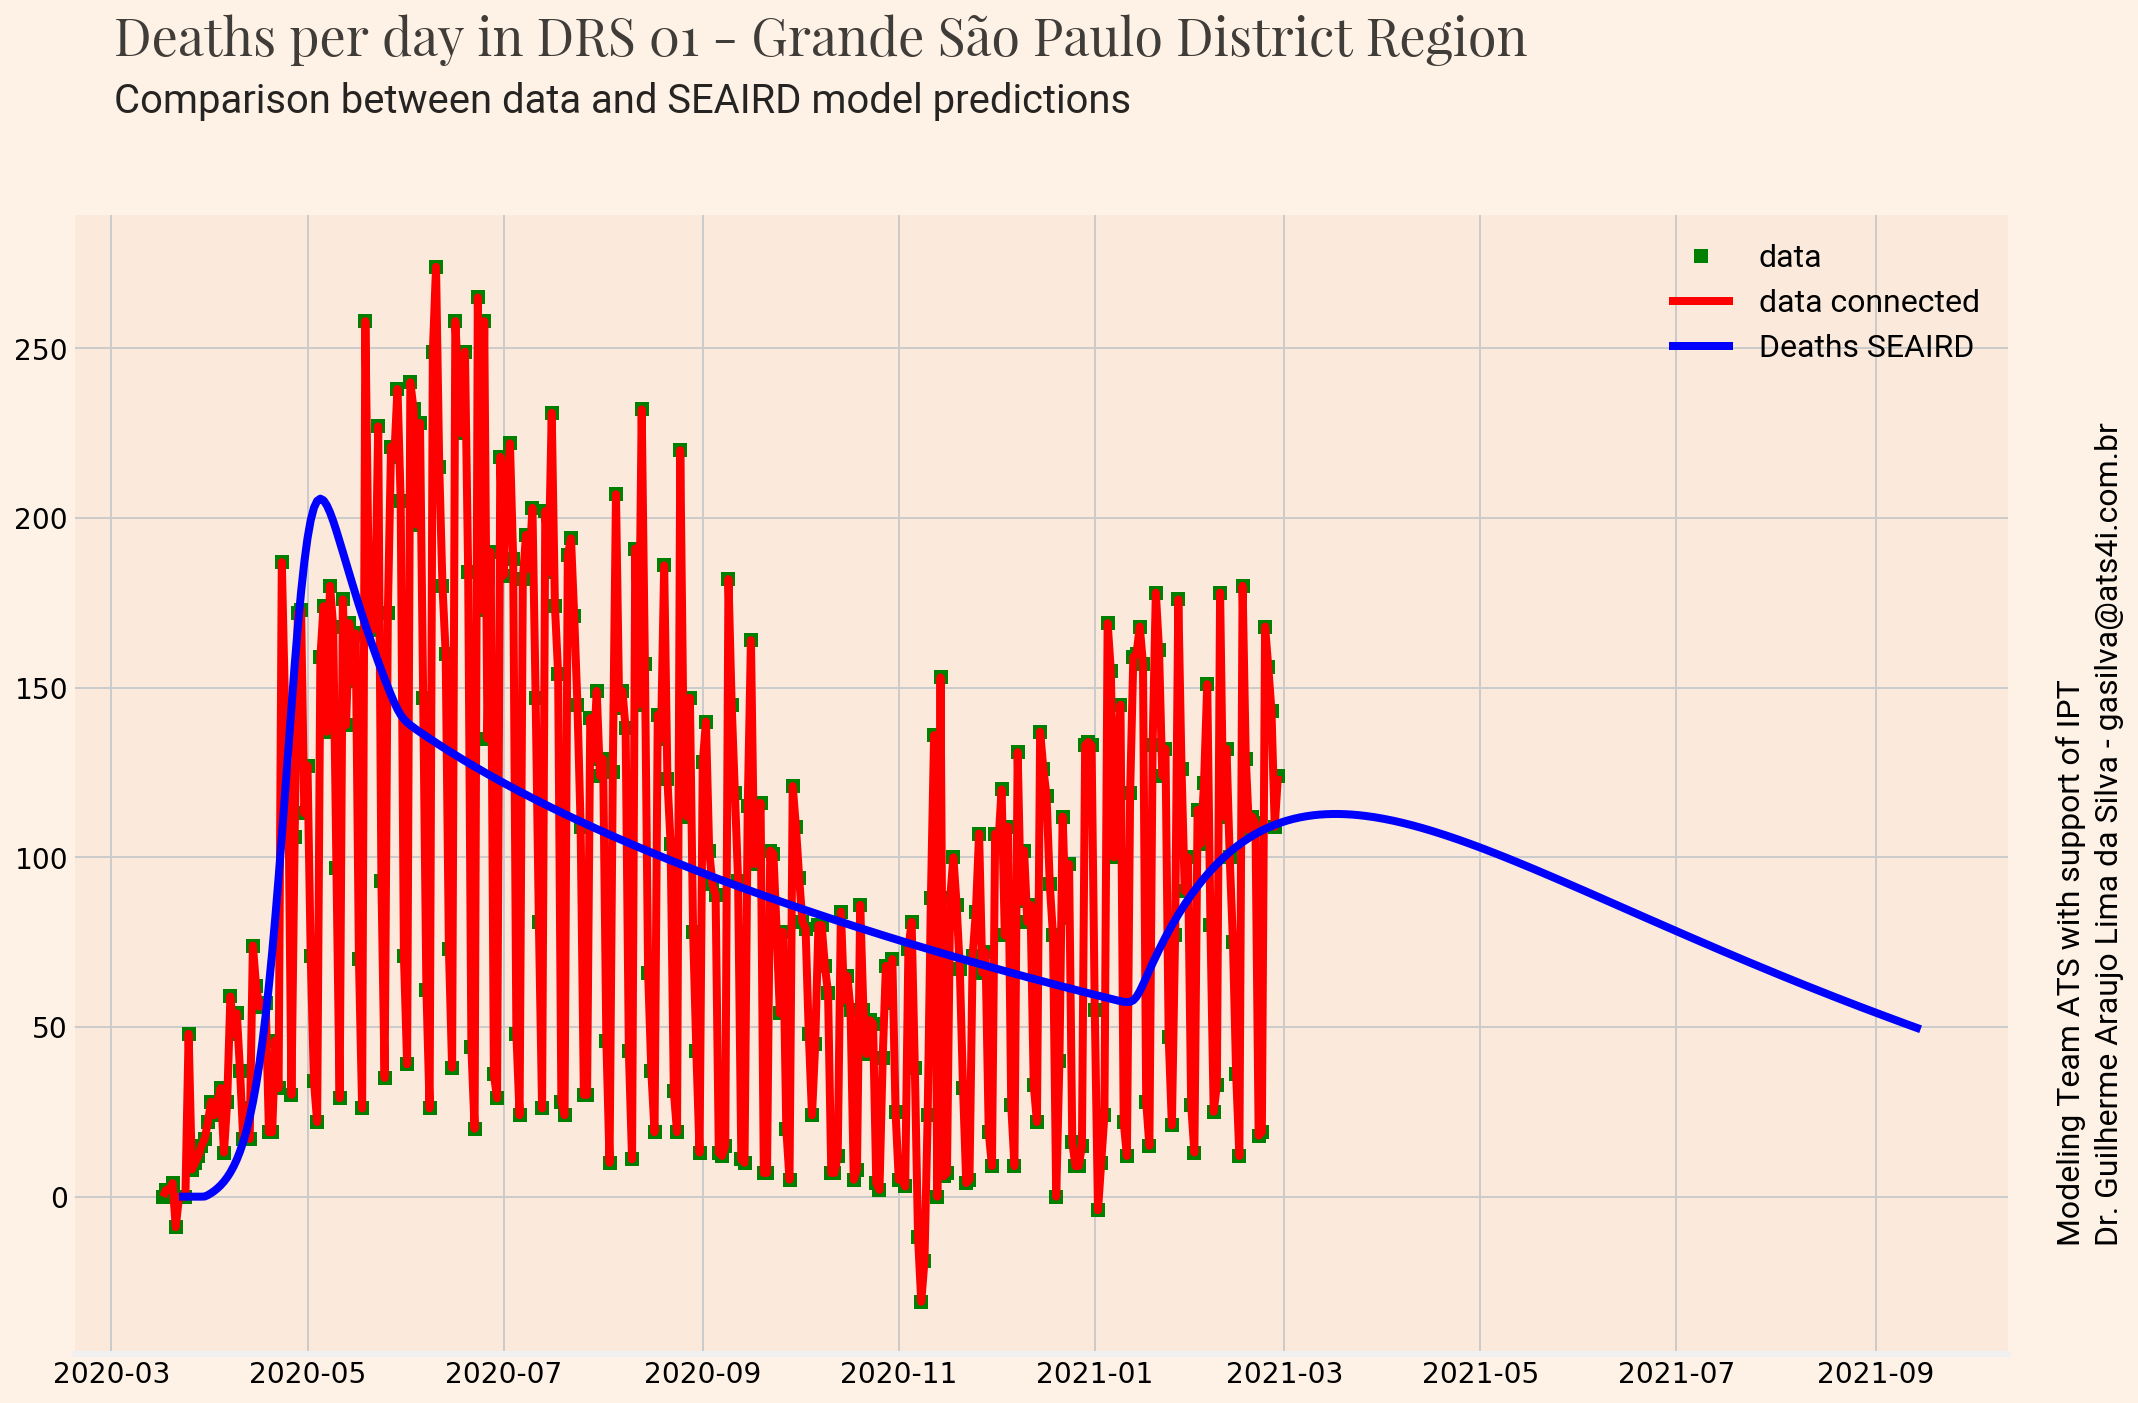

In [822]:
fig,ax = plotFT("Deaths per day in "+districtRegion+" District Region","Comparison between data and SEAIRD model predictions")
ax.plot(dead.date,dead['diff'],'gs',label='data')
ax.plot(dead.date,dead['diff'],'r-',label='data connected')

diffDeaths=np.diff(df['deaths'].values)
diffDeaths=np.insert(diffDeaths,0,0)
df['diffDeaths']=diffDeaths
ax.plot(df['diffDeaths'],'b',label='Deaths SEAIRD')
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)

In [823]:

# ARIMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = dead['diff'].values
# fit model
model = ARIMA(data, order=(5, 1, 1))
model_fit = model.fit()
display(model_fit.summary())
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)
pred=model_fit.get_forecast(steps=200).predicted_mean

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  348
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -1795.793
Date:                Mon, 01 Mar 2021   AIC                           3605.585
Time:                        19:38:55   BIC                           3632.530
Sample:                             0   HQIC                          3616.314
                                - 348                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1562      0.051     -3.086      0.002      -0.255      -0.057
ar.L2         -0.4820      0.040    -12.072      0.000      -0.560      -0.404
ar.L3         -0.4131      0.046     -8.909      0.000      -0.504      -0.322
ar.L4         -0.3623      0.046     -7.935      0.000      -0.452      -0.273
ar.L5         -0.5476      0.060     -9.200      0.000      -0.664      -0.431
ma.L1         -0.5962      0.058    -10.246      0.000      -0.710      -0.482
sigma2      1809.0240    110.121     16.428      0.000    1593.190    2024.858
===================================================================================
Ljung-Box (L1) (Q):                   9.08   Jarque-Bera (JB):                39.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.49
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[39.0001196]


array([-6.75735702e-02,  1.04542980e+02])

array([100.,  50.,   0., 100.])

100%|██████████| 500/500 [00:03<00:00, 165.96trial/s, best loss: 6152.562524328672] 


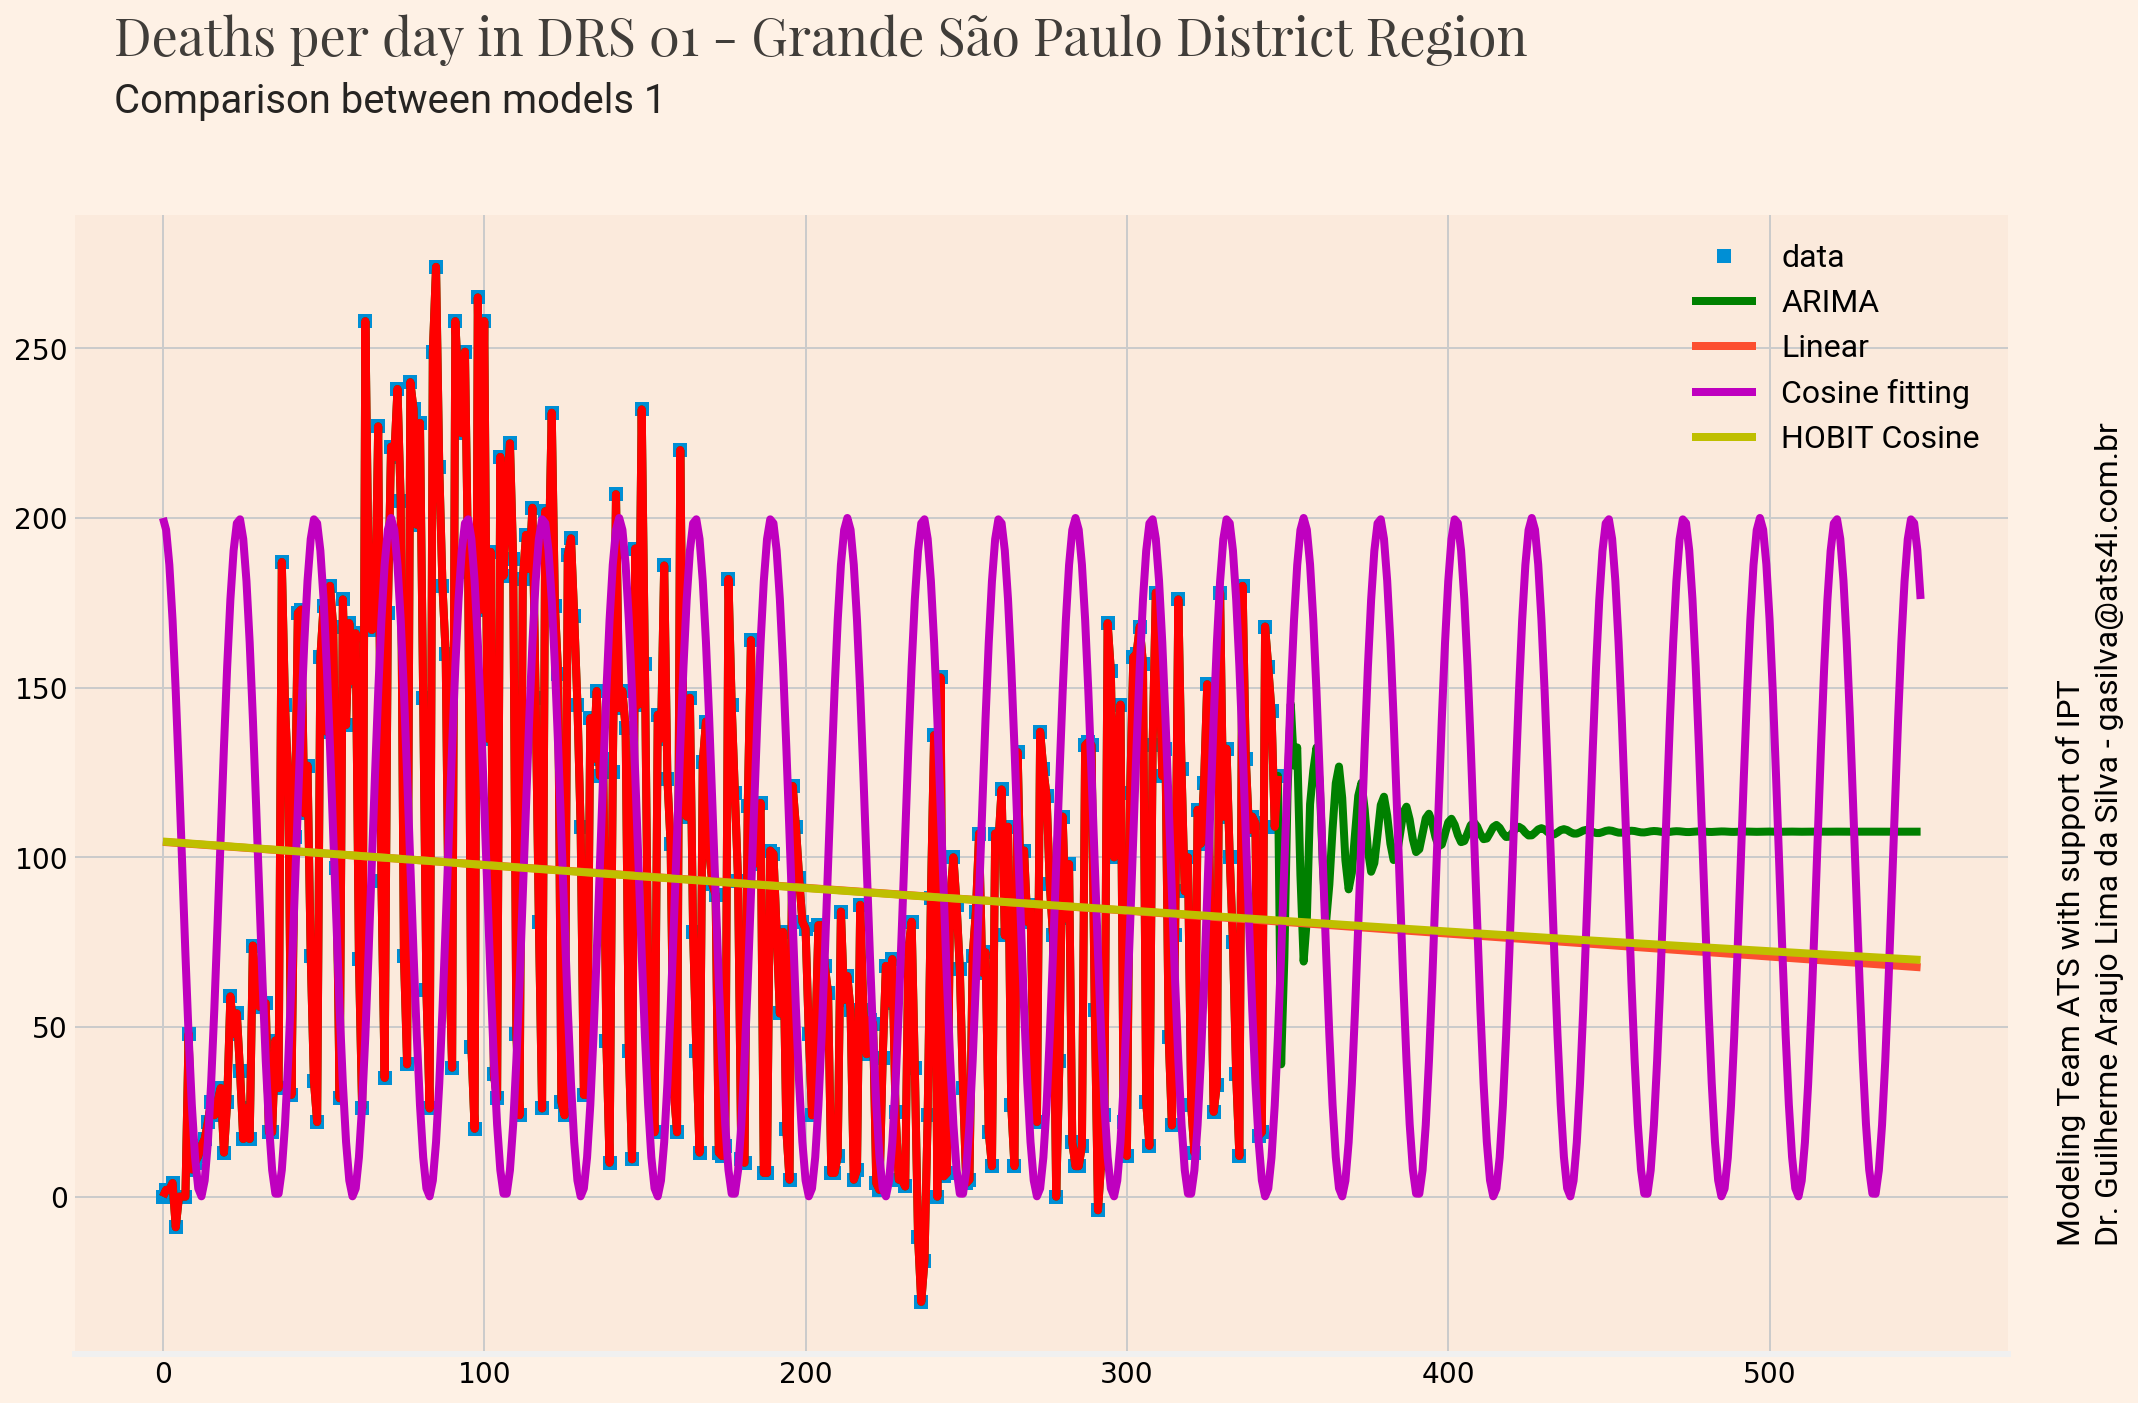

In [824]:
from scipy.optimize import curve_fit

fig,ax = plotFT("Deaths per day in "+districtRegion+" District Region","Comparison between models 1")

ax.plot(dead['diff'],'s',label="data")
tspan2=np.arange(0, size+200, 1)
pred2=np.append(dead.iloc[:,2].values,pred)
ax.plot(tspan2,pred2,'g-',label="ARIMA")
ax.plot(tspan1,results[0],'r-')

coef=np.polyfit(tspan, dead.iloc[:,2].values, 1)
display(coef)
pred3=tspan2*coef[0]+coef[1]
ax.plot(tspan2,pred3,label="Linear")

def deadFit(data,a,b,c,d):
    return a*np.cos(b*data-c)+d

fittedParameters, pcov =curve_fit(deadFit, tspan, dead.iloc[:,1].values,
                                 bounds=((0, 0, -np.pi, 0), (200, 100, np.pi, 200)))

display(fittedParameters)

a, b, c, d = fittedParameters

pred4=deadFit(tspan2,a,b,c,d)
ax.plot(tspan2,pred4,'m',label="Cosine fitting")

from HOBIT import RegressionForTrigonometric
from IPython.display import display, Math

seed = 12345512
trig_reg = RegressionForTrigonometric()
trig_reg.fit_cos(tspan, dead.iloc[:,2].values, max_evals=500, rstate=np.random.RandomState(seed))

trig_reg.best_parameters

y3 = trig_reg.predict(tspan2)
ax.plot(tspan2,y3,'y',label="HOBIT Cosine")
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)


In [825]:
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import hp, tpe, Trials, fmin
y_data=dead.iloc[:,2].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tspan, y_data, test_size=0.2, random_state=42)
ix=np.where(y_train>0)
X_train=X_train[ix]
y_train=y_train[ix]

In [826]:
def objective(a0, a1, w, f, gamma):
    """Objective function to minimize"""
    return np.mean((a0+ a1 * np.exp(-gamma*X_train)*np.cos(w*X_train + f) - y_train)**2)

In [827]:
def objective2(args):
    return objective(*args)

def objective3(p):
    a0, a1, w, f, gamma = p
    return np.mean((a0+ a1 * np.exp(-gamma*X_train)*np.cos(w*X_train + f) - y_train)**2)

def objective4(p):
    a0, a1, gamma = p
    ix=np.where(y_train>0)
    sol=a0-a1*np.exp(-gamma*X_train[ix])
#     sol=np.maximum(sol,0)
    return np.mean((sol - y_train[ix])**2)

def objective5(p,t):
    a0, a1, gamma = p
    return (a0-a1*np.exp(-gamma*t))


In [828]:
space = [hp.uniform('a0', 0, 200),
         hp.uniform('a1', 0, 200), 
         hp.uniform('w', 0, 0.5), 
         hp.uniform('f', -np.pi, np.pi),
         hp.uniform('gamma',0,0.0125)
        ]

tpe_algo = tpe.suggest
tpe_trials = Trials()

tpe_best = fmin(fn=objective2, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=5000, rstate=np.random.RandomState(seed))

print(tpe_best)

100%|██████████| 5000/5000 [04:12<00:00, 19.82trial/s, best loss: 3003.589511756584] 
{'a0': 89.03944299053126, 'a1': 142.6400288402549, 'f': -2.4440246993151167, 'gamma': 0.006215373833142218, 'w': 0.023737506386541235}


In [829]:
x_data=tspan2
y = tpe_best['a0'] + np.exp(-tpe_best['gamma']*x_data)*tpe_best['a1'] * np.cos(tpe_best['w'] * x_data + tpe_best['f'])

In [830]:
bnds = ((-200,200),(-200,200),(0,1))
x0 = [50,50,0.001]
minimizer_kwargs = { "method": "L-BFGS-B","bounds":bnds }
optimal = basinhopping(objective4, x0, minimizer_kwargs=minimizer_kwargs,niter=100) 
print(optimal.x)
print(optimal.fun)

[1.01390394e+02 1.49854806e+02 6.13631080e-02]
4201.96082739558


In [831]:
y2=objective5(optimal.x,tspan2)

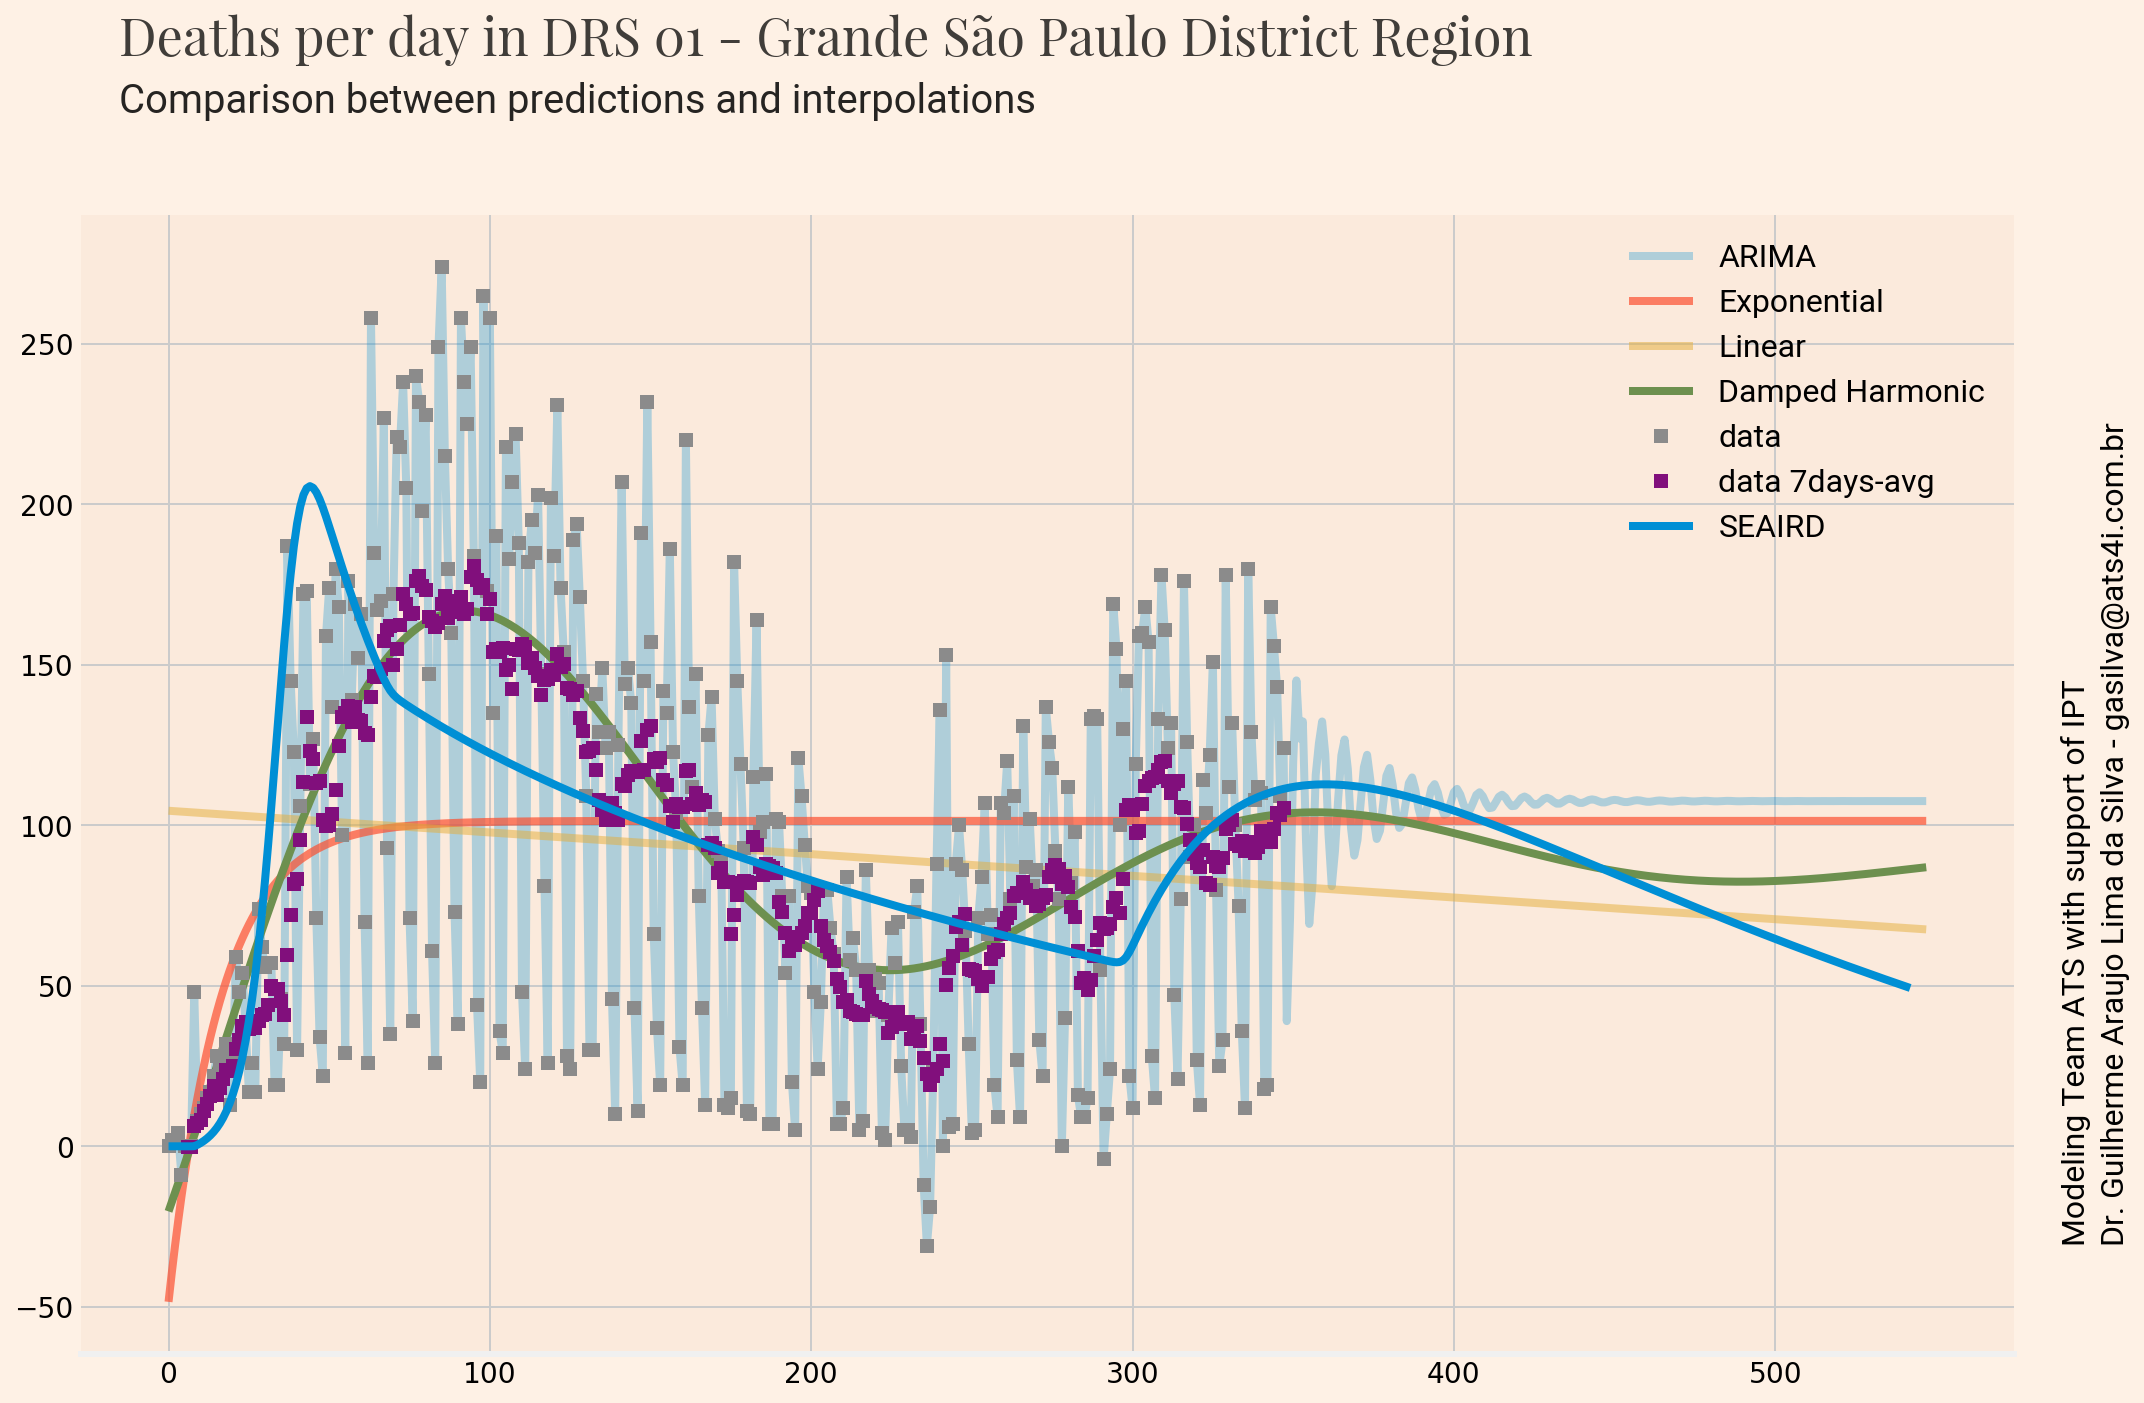

In [832]:
fig,ax = plotFT("Deaths per day in "+districtRegion+" District Region","Comparison between predictions and interpolations")



tspan2=np.arange(0, size+200, 1)
pred2=np.append(dead.iloc[:,2].values,pred)
ax.plot(tspan2,pred2,'-',label='ARIMA',alpha=0.3)
ax.plot(tspan2,y2,label='Exponential',alpha=0.7)
pred3=tspan2*coef[0]+coef[1]
ax.plot(tspan2,pred3,'-',label='Linear',alpha=0.5)
# ax.plot(tspan2,pred4,'b',label='cosine')
ax.plot(tspan2,y,label='Damped Harmonic',alpha=1)
ax.plot(dead['diff'],'s',label='data')
ax.plot(dead['diff'].rolling(window=7).mean(),'s',label='data 7days-avg')
size4=len(diffDeaths)
ax.plot(np.arange(0, size4, 1),diffDeaths,label='SEAIRD')
#ax.plot(tspan1,results[0],'-')
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)


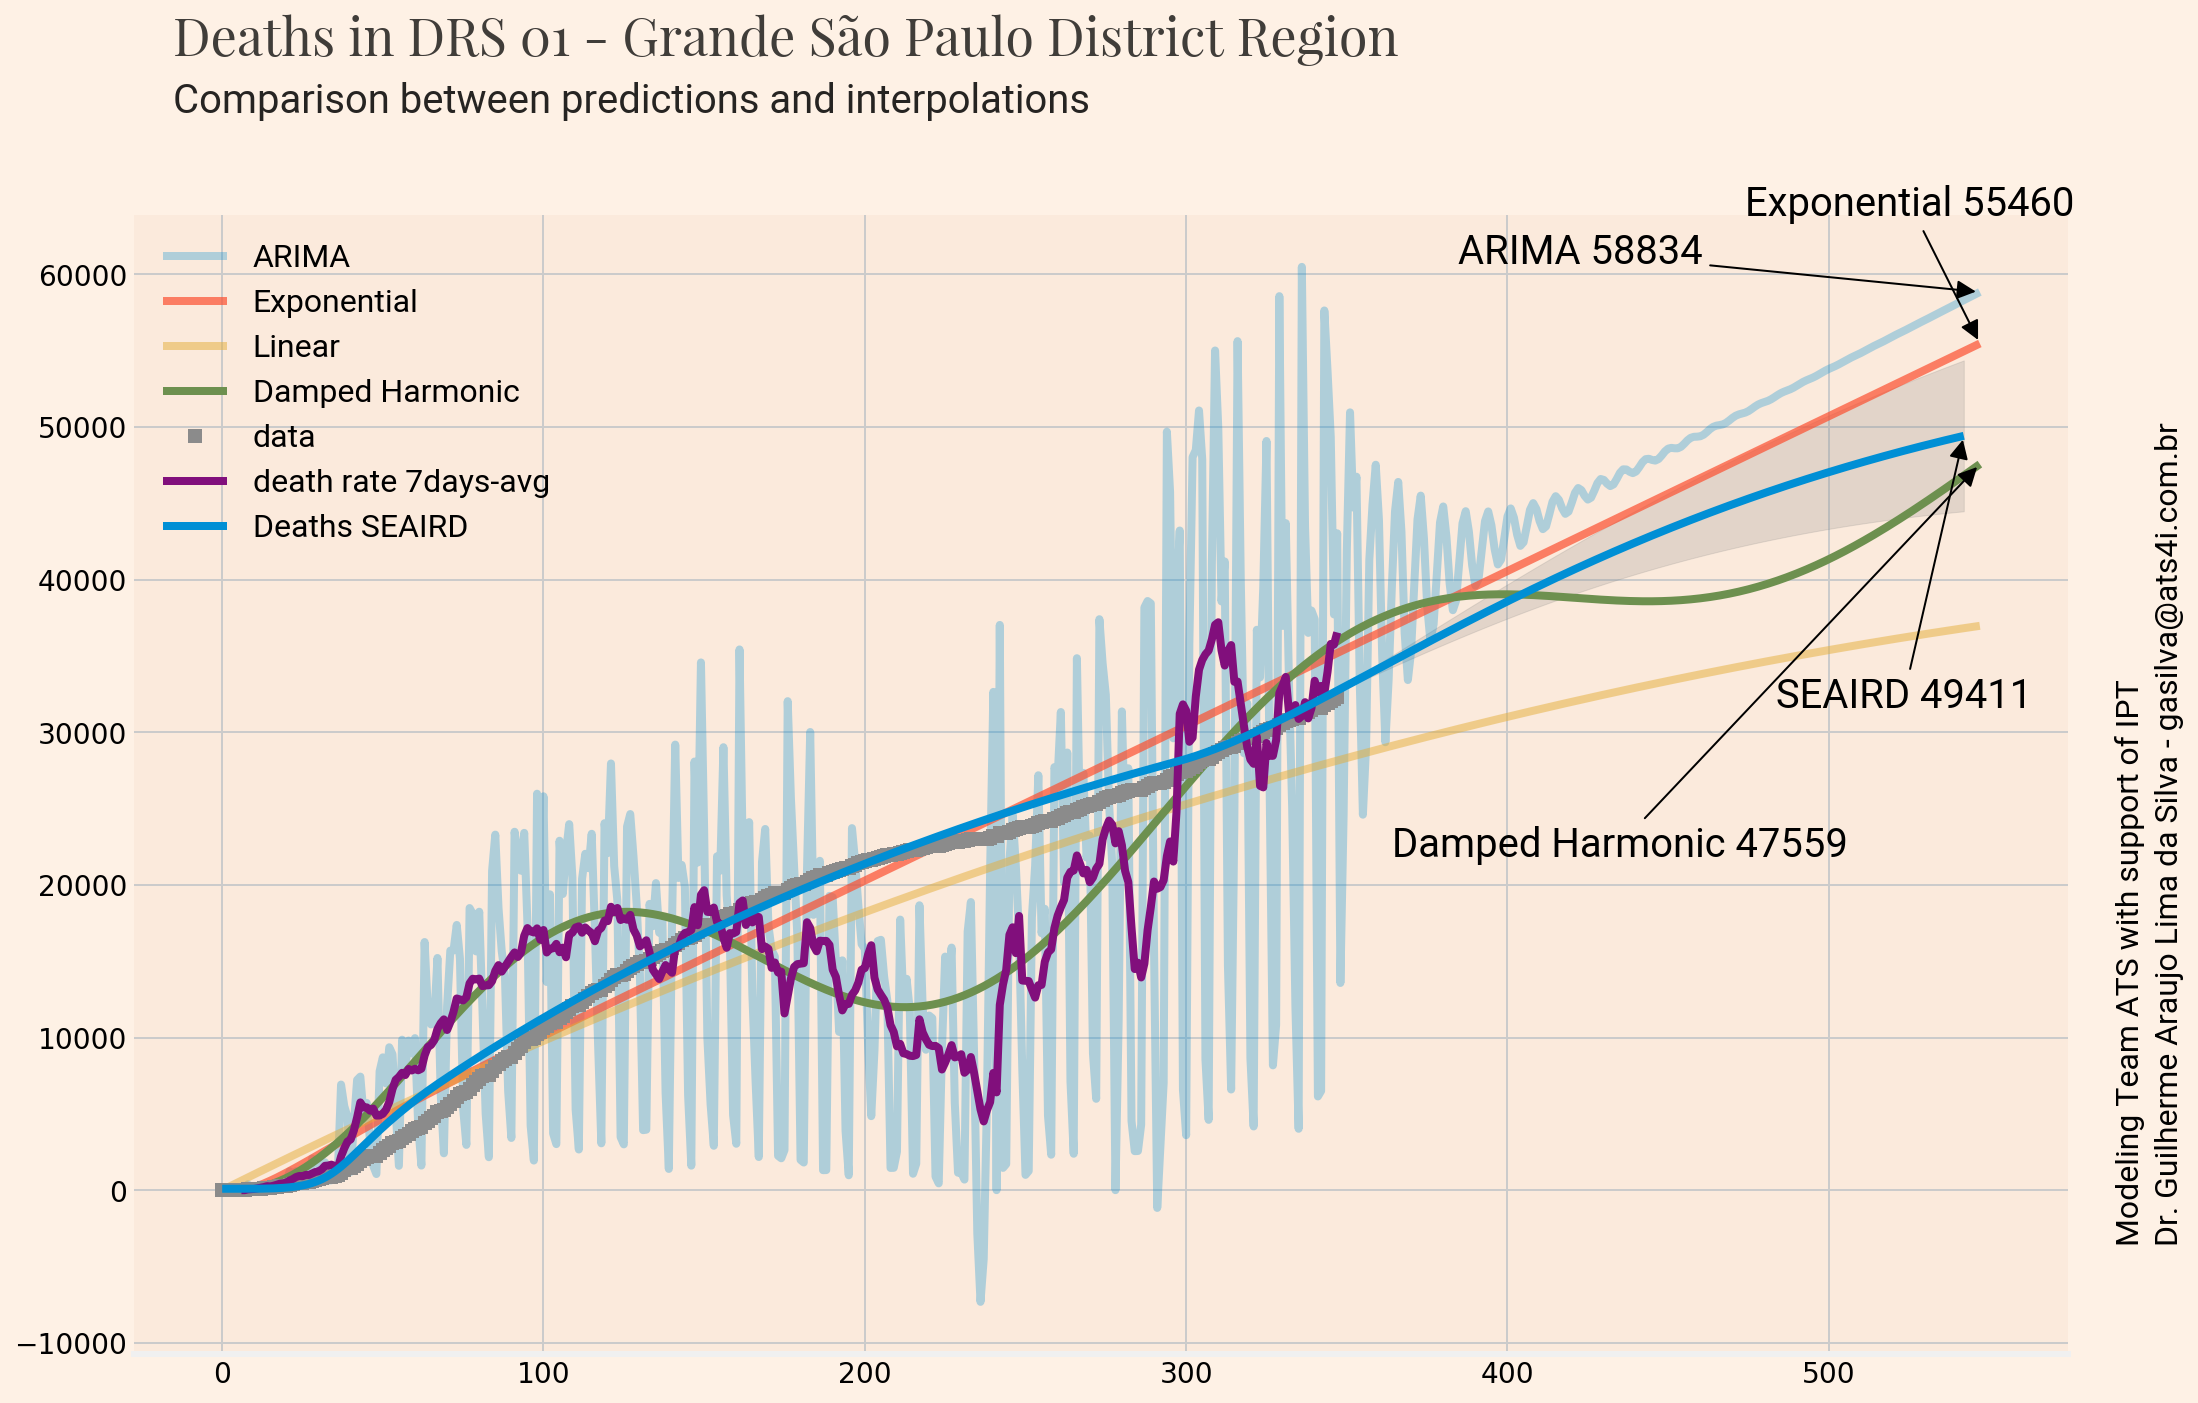

In [833]:
fig,ax = plotFT("Deaths in "+districtRegion+" District Region","Comparison between predictions and interpolations")


maxD=pred2[-1]*tspan2[-1]
maxInd=tspan2[-1]
ax.annotate("ARIMA {:}".format(int(pred2[-1]*tspan2[-1])), 
     xy=(maxInd,maxD), 
     xytext=(-200,10), textcoords='offset points', ha='center', va='bottom',
    arrowprops=dict(arrowstyle='-|>', color='black', lw=1),fontsize=20,fontproperties=subtitle_font)
ax.plot(tspan2,pred2*tspan2,label='ARIMA',alpha=0.3)

tspan3=np.arange(0, len(df['deaths'].values), 1)
maxD=y2[-1]*tspan2[-1]
maxInd=tspan2[-1]
ax.annotate("Exponential {:}".format(int(y2[-1]*tspan2[-1])), 
     xy=(maxInd,maxD), 
     xytext=(-35,60), textcoords='offset points', ha='center', va='bottom',
    arrowprops=dict(arrowstyle='-|>', color='black', lw=1),fontsize=20,fontproperties=subtitle_font)
ax.plot(tspan2,y2*tspan2,label='Exponential',alpha=0.7)

ax.plot(tspan2,pred3*tspan2,label='Linear',alpha=0.5)

maxD=y[-1]*tspan2[-1]
maxInd=tspan2[-1]
ax.annotate("Damped Harmonic {:}".format(int(y[-1]*tspan2[-1])), 
     xy=(maxInd,maxD), 
     xytext=(-180,-200), textcoords='offset points', ha='center', va='bottom',
    arrowprops=dict(arrowstyle='-|>', color='black', lw=1),fontsize=20,fontproperties=subtitle_font)
ax.plot(tspan2,y*tspan2,label='Damped Harmonic',alpha=1)

ax.plot(tspan,dead.iloc[:,0].values,'s',label='data')
ax.plot(tspan,dead['diff'].rolling(window=7).mean()*tspan,'-',label='death rate 7days-avg')


maxD=max(df['deaths'])
maxInd=tspan3[df['deaths']==max(df['deaths'])][0]
ax.annotate("SEAIRD {:}".format(int(df['deaths'].nlargest(1))), 
     xy=(maxInd,maxD), 
     xytext=(-30,-140), textcoords='offset points', ha='center', va='bottom',
    arrowprops=dict(arrowstyle='-|>', color='black', lw=1),fontsize=20,fontproperties=subtitle_font)

ax.plot(tspan3,df['deaths'].values,'-',label="Deaths SEAIRD")

plt.fill_between(tspan3,df['deaths']-df['error'],df['deaths']+df['error']
                 ,color='gray', alpha=0.2)

#ax.set_yscale('log')
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)
